In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

from functions.plot_metrics import plot_metrics
from functions.plot_metrics_one import plot_metrics_one
from functions import calc_metrics

2024-05-03 07:43:50.075076: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 07:43:50.108939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 07:43:50.108959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 07:43:50.109801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 07:43:50.115582: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_water=parse.parse('cloudrm3_water_newsurf.dat')
data_clear=parse.parse('cloudrm3_clear_newsurf.dat')
data_ice=parse.parse('cloudrm3_ice_newsurf.dat')
data_mixed=parse.parse('cloudrm3_mixed_newsurf.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water,data_clear,data_ice,data_mixed,
#                    data_black_water,data_black_clear,data_black_ice,data_black_mixed])
data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])


data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13','Sun_Zenith_Angle']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
#clear_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

#y_labels= ['OCloud_B02','OCloud_B03','OCloud_B04','OCloud_B05','OCloud_B06',
#           'OCloud_B07','OCloud_B08','OCloud_B09','OCloud_B10','OCloud_B11','OCloud_B12','OCloud_B13']

#df[y_labels]=df[X_labels].to_numpy()-df[clear_labels].to_numpy()

In [3]:
## Estimate COT ##
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_load_paths=['cot_model/0/model_it_2000000','cot_model/1/model_it_2000000',
                  'cot_model/2/model_it_2000000','cot_model/3/model_it_2000000',
                  'cot_model/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]

inputs = (df[X_labels].to_numpy() - means) / stds

image_input_tens=torch.Tensor(inputs).to(device)
#image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50

preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=preds.cpu().data.numpy()*50 #unnormalise

## Reshape back
t_is_cloud = 0.025*50 # From Alex
t_thin_cloud = 0.015*50 # From Alex

im_pred_cot_t=image_pred_cot.copy()
im_pred_cot_t[im_pred_cot_t<t_thin_cloud]=0
im_pred_cot_t[(im_pred_cot_t>t_thin_cloud)&(im_pred_cot_t<t_is_cloud)]=1
im_pred_cot_t[im_pred_cot_t>t_is_cloud]=2
column_name='COT_est'
c1='clear'
c2='thin'
c3='thick'
df[column_name]=im_pred_cot_t
df.loc[df[column_name]==0,c1]=1
df.loc[df[column_name]!=0,c1]=0
df.loc[df[column_name]==1,c2]=1
df.loc[df[column_name]!=1,c2]=0
df.loc[df[column_name]==2,c3]=1
df.loc[df[column_name]!=2,c3]=0

#X_labels.append(c1)
#X_labels.append(c2)
#X_labels.append(c3)

In [4]:
X=df[X_labels]
y=df[y_labels]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [5]:
X_train

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,Cloud_B12,Cloud_B13,Sun_Zenith_Angle
98730,0.17217,0.15823,0.19790,0.22725,0.27004,0.30248,0.31154,0.34035,0.13504,0.00050,0.37417,0.30590,63.23
46077,0.31439,0.29872,0.33535,0.37758,0.46482,0.50574,0.48703,0.54550,0.12799,0.00137,0.60205,0.46846,72.78
138889,0.54002,0.48904,0.52213,0.49087,0.63333,0.71633,0.61427,0.75891,0.03039,0.00057,0.07831,0.08145,74.47
129252,0.51449,0.40908,0.47239,0.51215,0.53381,0.54571,0.54694,0.56177,0.45953,0.10441,0.10235,0.12017,83.98
83060,0.12646,0.08856,0.07171,0.06356,0.06332,0.06344,0.05485,0.06140,0.00766,0.00051,0.04649,0.03281,66.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134901,0.66827,0.64335,0.66250,0.70518,0.88497,1.01412,0.99859,1.01617,0.79411,0.35729,0.14819,0.17985,43.85
38760,0.67518,0.56665,0.59961,0.55564,0.59151,0.63238,0.55889,0.65580,0.14192,0.00078,0.41484,0.33869,77.94
187693,0.73838,0.69389,0.72977,0.75249,0.77178,0.78174,0.76793,0.78723,0.68978,0.27482,0.13497,0.15776,64.32
155175,0.42982,0.39540,0.42637,0.45214,0.48961,0.51042,0.50715,0.53458,0.29961,0.01658,0.54056,0.45317,68.24


In [6]:
X_train = X_train + np.random.randn(np.shape(X_train)[0],np.shape(X_train)[1]) * np.mean(X_train.to_numpy(),axis=0)*0.03
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.03

In [7]:
#Normalise
X_mean=np.mean(X_train,axis=0).to_numpy()
X_std=np.std(X_train,axis=0).to_numpy()
X_train=(X_train-X_mean)/X_std

X_test=(X_test-X_mean)/X_std


In [8]:
print(np.mean(X_train,axis=0).to_numpy())
print(np.std(X_train,axis=0).to_numpy())
print(" ")
print(np.mean(X_test,axis=0).to_numpy())
print(np.std(X_test,axis=0).to_numpy())

[ 5.64481795e-16  6.68576305e-17  2.81463741e-16  2.46558329e-16
 -2.29194441e-16  9.45910017e-18  1.36601841e-16  6.42152997e-17
  7.35411732e-17  1.36557432e-16 -3.72146758e-17  1.56230584e-16
  3.25828253e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 
[ 0.00274595  0.00475714  0.00442489  0.00412345  0.00384164  0.00280281
  0.00430296  0.00486619  0.00700954  0.00690501  0.00365485  0.00375303
 -0.00670781]
[1.00112711 1.00008053 0.99775188 0.99518058 0.99612777 0.99693753
 0.99679389 0.99658344 1.00118514 1.00479184 0.9979852  0.99607018
 0.99909285]


In [9]:
def custom_learning_rate(iterations):
  """
  This function reduces the learning rate by 0.1 every 10 iterations.
  """
  return 0.1 * (1.0 - (iterations / 10))

In [10]:
import cupy as cp
import xgboost as xgb
# Define your training and target data (replace with your actual data)
# Your training features
# Your training target values

# Create the XGBoost regressor model
X_train_gpu = cp.asarray(X_train.to_numpy())
y_train_gpu = cp.asarray(y_train.to_numpy())

model = xgb.XGBRegressor(device='cuda',n_estimators=500,
                         max_depth=5,
                         learning_rates=custom_learning_rate,
                         loss='squared_error')

# Train the model on the training data
model.fit(X_train_gpu, y_train_gpu)

# Make predictions on new data (replace with your new data)
X_new = X_test# Your new features
y_pred = model.predict(X_new)


/home/edgelab/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:43:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)
/home/edgelab/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:44:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [11]:
mean_squared_error(y_test,y_pred)

0.006702184931531394

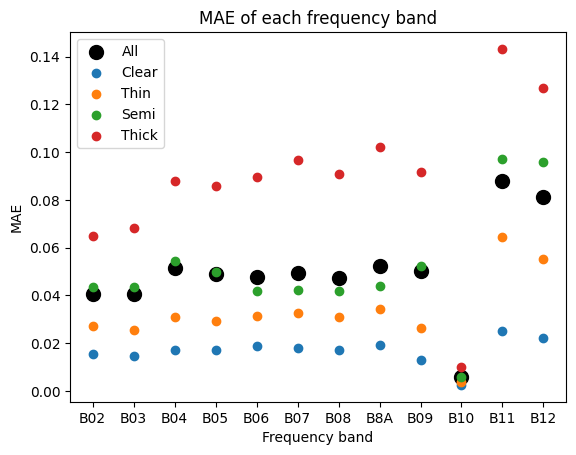

In [12]:
testindices=y_test.index
COTs=np.array(df['COT'].iloc[testindices])

#Divide into bins depending on COT
clear_true = y_test.to_numpy()[(COTs==0),:]
clear_pred = y_pred[(COTs==0),:]
thin_true = y_test.to_numpy()[(COTs>0) &  (COTs<3.6),:]
thin_pred = y_pred[(COTs>0) & (COTs<3.6),:]
semi_true = y_test.to_numpy()[(COTs>=3.6) & (COTs<23),:]
semi_pred = y_pred[(COTs>=3.6) & (COTs<23),:]
thick_true = y_test.to_numpy()[(COTs>=23),:]
thick_pred = y_pred[(COTs>=23),:]


#Find and print MAE of each band
MAE_col_tot = np.mean(np.abs(y_test.to_numpy()-y_pred),axis=0)
MAE_col_clear = np.mean(np.abs(clear_true-clear_pred),axis=0)
MAE_col_thin = np.mean(np.abs(thin_true-thin_pred),axis=0)
MAE_col_semi = np.mean(np.abs(semi_true-semi_pred),axis=0)
MAE_col_thick = np.mean(np.abs(thick_true-thick_pred),axis=0)

x=np.arange(np.size(MAE_col_tot))
plt.figure()
plt.scatter(x,MAE_col_tot,c='black',s=100)
plt.scatter(x,MAE_col_clear)
plt.scatter(x,MAE_col_thin)
plt.scatter(x,MAE_col_semi)
plt.scatter(x,MAE_col_thick)
plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['All','Clear','Thin','Semi','Thick'])
plt.show()

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Ground Truth')

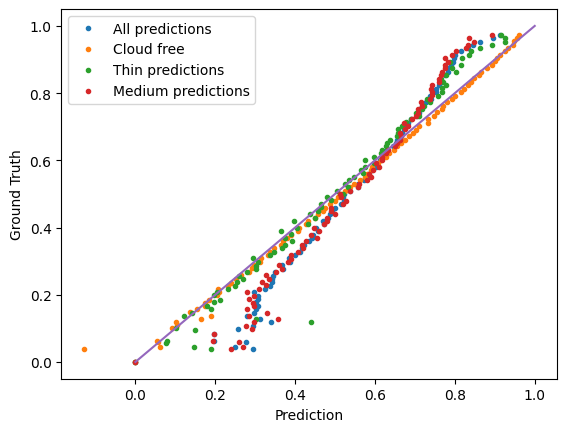

In [13]:
band=10
## Prediction v Ground Truth ##
y_true=y_test.to_numpy()[:,band]
pred_y_11=y_pred[:,band]
bins=np.linspace(0,1,100)

freq_true=np.zeros(len(bins))
freq_pred=np.zeros(len(bins))

freq_true_zero=np.zeros(len(bins))
freq_pred_zero=np.zeros(len(bins))

freq_true_thin=np.zeros(len(bins))
freq_pred_thin=np.zeros(len(bins))

freq_true_med=np.zeros(len(bins))
freq_pred_med=np.zeros(len(bins))

y_tmp_zero=clear_true[:,band]
y_tmp_thin=thin_true[:,band]
y_tmp_med=semi_true[:,band]

y_tmp_pred_zero=clear_pred[:,band]
y_tmp_pred_thin=thin_pred[:,band]
y_tmp_pred_med=semi_pred[:,band]

for j,edge in enumerate(bins):
    if j!=0:
        indices=(y_true>bins[j-1])&(y_true<=edge)

        ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
        ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
        ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

        mean_bin_true=np.mean(y_true[indices])
        mean_bin_pred=np.mean(pred_y_11[indices])

        mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
        mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z])

        mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
        mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t])

        mean_bin_true_med=np.mean(y_tmp_med[ind_m])
        mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m])
        
        freq_true[j]=mean_bin_true
        freq_pred[j]=mean_bin_pred

        freq_true_zero[j]=mean_bin_true_zero
        freq_pred_zero[j]=mean_bin_pred_zero

        freq_true_thin[j]=mean_bin_true_thin
        freq_pred_thin[j]=mean_bin_pred_thin

        freq_true_med[j]=mean_bin_true_med
        freq_pred_med[j]=mean_bin_pred_med

plt.plot(freq_pred,freq_true,'.')
plt.plot(freq_pred_zero,freq_true_zero,'.')
plt.plot(freq_pred_thin,freq_true_thin,'.')
plt.plot(freq_pred_med,freq_true_med,'.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
plt.plot(line,line)
plt.legend(['All predictions','Cloud free','Thin predictions','Medium predictions'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")

In [14]:
test_indices=X_test.index
df_test=df.loc[test_indices]
df_test=df_test.reset_index()
df_test_clear=df_test[df_test['COT']==0]
df_test_thin=df_test[(df_test['COT']<=3.6) & (df_test['COT']>0)]
df_test_med=df_test[(df_test['COT']<=23) & (df_test['COT']>3.6)]
df_test_thick=df_test[(df_test['COT']<=50) & (df_test['COT']>23)]

In [15]:

MSE_cot_levels=[]
MSE_cot_levels.append(mean_squared_error(y_test.to_numpy(),y_pred))
MSE_cot_levels.append(mean_squared_error(y_test.to_numpy()[df_test_clear.index],y_pred[df_test_clear.index,:]))
MSE_cot_levels.append(mean_squared_error(y_test.to_numpy()[df_test_thin.index],y_pred[df_test_thin.index,:]))
MSE_cot_levels.append(mean_squared_error(y_test.to_numpy()[df_test_med.index],y_pred[df_test_med.index,:]))
MSE_cot_levels.append(mean_squared_error(y_test.to_numpy()[df_test_thick.index],y_pred[df_test_thick.index,:]))

In [16]:
print("MSE all test data: "+str(MSE_cot_levels[0]))
print("MSE clear test data: "+str(MSE_cot_levels[1]))
print("MSE thin COT <3.6 test data: "+str(MSE_cot_levels[2]))
print("MSE med COT <23 test data: "+str(MSE_cot_levels[3]))
print("MSE thick COT <50 test data: "+str(MSE_cot_levels[4]))

MSE all test data: 0.006702184931531394
MSE clear test data: 0.0006911292089702018
MSE thin COT <3.6 test data: 0.002625077055659621
MSE med COT <23 test data: 0.005716773226330424
MSE thick COT <50 test data: 0.015428670120986998


In [17]:
model.feature_importances_

array([0.08174884, 0.0662875 , 0.0423396 , 0.02547151, 0.02273349,
       0.06739157, 0.0502486 , 0.4138615 , 0.05924804, 0.01343425,
       0.06294192, 0.03026181, 0.06403134], dtype=float32)